# One-Step Ahead Prediction via Standard Averaging

Predict the future consumption (for example, $x_{t+1}$ ) as an average of the previously observed consumption within a fixed size window (for example, $x_{t-N}$, ..., $x_t$) (say previous 5 hours).

In [1]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75

In [2]:
# read csv  
industrial = pd.read_csv('data/industrial_total.csv')

In [3]:
industrial.head()

,cumulative,difference,time
0,19141.294,NaN,2015-10-27T11:23:00+0100
1,19142.559,1.265,2015-10-27T11:24:00+0100
2,19143.823,1.264,2015-10-27T11:25:00+0100
3,19146.248,2.425,2015-10-27T11:26:00+0100
4,19147.457,1.209,2015-10-27T11:27:00+0100


In [4]:
# create hourly dataset
d = {'difference': 'mean', 'time': 'first'}
# average over every 60 minutes
hourly = industrial.groupby(industrial.index // 60).agg(d)
hourly['hour'] = hourly.index + 1

In [5]:
hourly = hourly.rename(columns={"difference": "mean"})

In [6]:
hourly.head()

,mean,time,hour
0,1.705864,2015-10-27T11:23:00+0100,1
1,2.296767,2015-10-27T12:23:00+0100,2
2,2.270200,2015-10-27T13:23:00+0100,3
3,2.138400,2015-10-27T14:23:00+0100,4
4,2.092150,2015-10-27T15:23:00+0100,5


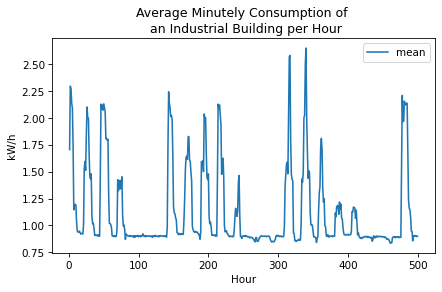

In [7]:
# visualize first 500 values of the hourly data
hourly.head(500).plot(x = 'hour', 
                        y = 'mean',
                        title = 'Average Minutely Consumption of \n an Industrial Building per Hour',
                        xlabel = 'Hour',
                        ylabel = 'kW/h')

plt.tight_layout()

In [8]:
# look at size to train
hourly.shape[0]

14076

In [9]:
# create test and train datasets
train_data = hourly['mean'][:11000].array
test_data = hourly['mean'][11000:].array

In [10]:
# check lengths
len(train_data), len(test_data)

(11000, 3076)

In [11]:
# scale the data to be between 0 and 1 then reshape it
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [12]:
# train the scaler with training data and smooth data
# we chose a smoothing window of 5 hours
smoothing_window_size = 5
for di in range(0, 10500, smoothing_window_size):
    scaler.fit(train_data[di : di+smoothing_window_size, :])
    train_data[di : di+smoothing_window_size, :] = scaler.transform(train_data[di : di+smoothing_window_size, :])

# you normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [13]:
# reshape both train and test data
train_data = train_data.reshape(-1)

# rormalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [21]:
# smooth the data with exponential moving average   
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma * train_data[ti] + (1-gamma) * EMA
  train_data[ti] = EMA

# used for visualization and test purposes
all_data = np.concatenate([train_data, test_data], axis=0)

In [23]:
window_size = 5
N = train_data.size
# initialize array of predictions
std_avg_predictions = []
# initialize array of dates
std_avg_x = []

# initialize array of mse
mse_errors = []

for pred_idx in range(window_size, N):

    if pred_idx >= N: # if we are in the testing data use the timestamp
        date = dt.datetime.strptime(hourly.loc[pred_idx,'time'].split('+')[0], '%Y-%m-%dT%H:%M:%S') + dt.timedelta(hours = 1)

    else: # else use the time value in the training data 
        date = hourly.loc[pred_idx,'time']


    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

# compute mse
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00186


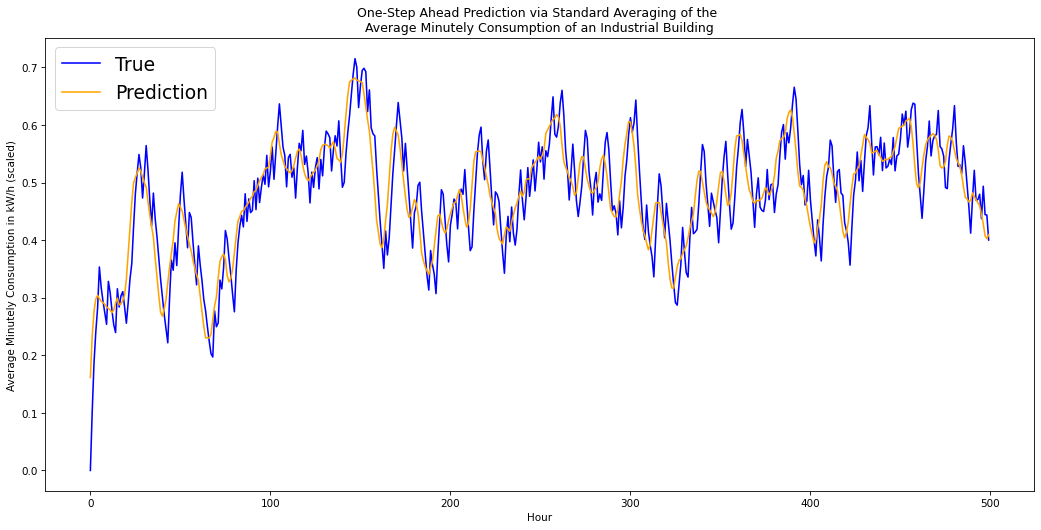

<Figure size 450x300 with 0 Axes>

In [27]:
plt.figure(figsize = (17,8))
plt.plot(all_data[:500], color='b', label='True')
plt.plot(std_avg_predictions[:500], color='orange', label='Prediction')
plt.xlabel('Hour')
plt.ylabel('Average Minutely Consumption in kW/h (scaled)')
plt.title('One-Step Ahead Prediction via Standard Averaging of the \nAverage Minutely Consumption of an Industrial Building')
plt.legend(fontsize=18)
plt.show()
plt.tight_layout()